# API

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import numpy.matlib
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# from SSH import *
# %load_ext line_profiler

In [2]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [485]:
# ipcluster start --engines=MPI
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from SSH import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [19]:
%%writefile SSH.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
from scipy import integrate


class Params:
    def __init__(self,
    L=100,
    delta=0,
    T=0,
    dmax=100,
    bc=-1):
        self.L=L
        self.delta=delta
        self.T=T
        if L<np.inf:
            self.v=1-delta
            self.w=1+delta
            self.bc=bc
            band=np.vstack([np.ones(L)*self.v,np.ones(L)*self.w]).flatten('F')
            Ham=np.diag(band[:-1],1)
            Ham[0,-1]=self.w*bc
            self.Hamiltonian=-(Ham+Ham.T)
        else:
            self.dmax=dmax
    
    def bandstructure(self):
        val,vec=nla.eigh(self.Hamiltonian)
        sortindex=np.argsort(val)
        self.val=val[sortindex]
        self.vec=vec[:,sortindex]    

    def E_k(self,k,branch):
        '''
        branch = +/-1
        '''
        return branch*np.sqrt(2*(1+self.delta**2)+2*(1-self.delta**2)*np.cos(k))

        
    def fermi_dist_k(self,k,branch,E_F=0):
        if self.T==0:
            return np.heaviside(E_F-self.E_k(k,branch),0)
        else:
            return 1/(1+np.exp((self.E_k(k,branch)-E_F)/self.T))


    def fermi_dist(self,energy,E_F):      
        if self.T==0:
            return np.heaviside(E_F-energy,0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T)) 


    def correlation_matrix_inf(self):
        '''
        self.dmax: the maximal distance (in terms of unit cell) 
        '''
        assert self.L==np.inf, "Wire length should be inf"
        cov_mat=[]
        for d in range(self.dmax):
            integrand_11=lambda k:2*np.cos(k*d)*(self.fermi_dist_k(k,1)+self.fermi_dist_k(k,-1))
            if self.T>0:
                integrand_11=lambda k:2*np.cos(k*d)*(self.fermi_dist_k(k,1)+self.fermi_dist_k(k,-1))
                integrand_12=lambda k:-np.sqrt(2)*((1-self.delta)*np.cos(k*d)+(1+self.delta)*np.cos(k*(d-1)))/np.sqrt((1+self.delta**2)+(1-self.delta**2)*np.cos(k))*(self.fermi_dist_k(k,1)-self.fermi_dist_k(k,-1))
                integrand_21=lambda k:-np.sqrt(2)*((1-self.delta)*np.cos(k*d)+(1+self.delta)*np.cos(k*(d+1)))/np.sqrt((1+self.delta**2)+(1-self.delta**2)*np.cos(k))*(self.fermi_dist_k(k,1)-self.fermi_dist_k(k,-1))
            else:
                # integrand_11=lambda k:2*np.cos(k*d)
                integrand_12=lambda k:np.sqrt(2)*((1-self.delta)*np.cos(k*d)+(1+self.delta)*np.cos(k*(d-1)))/np.sqrt((1+self.delta**2)+(1-self.delta**2)*np.cos(k))
                integrand_21=lambda k:np.sqrt(2)*((1-self.delta)*np.cos(k*d)+(1+self.delta)*np.cos(k*(d+1)))/np.sqrt((1+self.delta**2)+(1-self.delta**2)*np.cos(k))
            A_11=2*np.pi if d==0 else 0
            A_12=integrate.quad(integrand_12,0,np.pi)
            A_21=integrate.quad(integrand_21,0,np.pi)
            cov_mat.append(np.array([[A_11,A_12[0]],[A_21[0],A_11]])/(4*np.pi))

        Gamma=np.zeros((2*self.dmax,2*self.dmax))
        for i in range(self.dmax):
            for j in range(i):
                Gamma[2*i:2*i+2,2*j:2*j+2]=cov_mat[i-j]
        Gamma=Gamma+Gamma.T
        for i in range(self.dmax):
            Gamma[2*i:2*i+2,2*i:2*i+2]=cov_mat[0]

        self.C_f=Gamma

    def correlation_matrix_inf_fft(self,threshold=1024):
        '''
        self.dmax: the maximal distance (in terms of unit cell) 
        Directly call fft to evaluate the integral
        '''
        assert self.L==np.inf, "Wire length should be inf"
        cov_mat=[]
        d=max(self.dmax,threshold)
        if self.T>0:
            pass    #to be filled
        else:
            integrand_12=lambda k: ((1-self.delta) + (1+self.delta)*np.cos(k) - 1j*(1+self.delta)*np.sin(k))/np.sqrt((1-self.delta + (1+self.delta)* np.cos(k))**2+((1+self.delta)*np.sin(k))**2)
            integrand_21=lambda k: ((1-self.delta) + (1+self.delta)*np.cos(k) + 1j*(1+self.delta)*np.sin(k))/np.sqrt((1-self.delta + (1+self.delta)* np.cos(k))**2+((1+self.delta)*np.sin(k))**2)
            
            A_11=np.array([0.5]+[0]*(d-1))
            A_12=np.fft.ifft(integrand_12(np.arange(0,2*np.pi,2*np.pi/d)))/2
            A_21=np.fft.ifft(integrand_21(np.arange(0,2*np.pi,2*np.pi/d)))/2
            A_12=np.sign(np.real(A_12))*np.abs(A_12)
            A_21=np.sign(np.real(A_21))*np.abs(A_21)

        mat=np.array([[A_11,A_12],[A_21,A_11]])
        Gamma=np.zeros((2*self.dmax,2*self.dmax))
        for i in range(self.dmax):
            for j in range(i):
                Gamma[2*i:2*i+2,2*j:2*j+2]=mat[:,:,i-j]
        Gamma=Gamma+Gamma.T
        for i in range(self.dmax):
            Gamma[2*i:2*i+2,2*i:2*i+2]=mat[:,:,0]
        self.C_f=Gamma


    def correlation_matrix(self,E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self,'val') and hasattr(self,'vec')):
            self.bandstructure()
        occupancy_mat=np.matlib.repmat(self.fermi_dist(self.val,E_F),self.vec.shape[0],1)
        self.C_f=np.real((occupancy_mat*self.vec)@self.vec.T.conj())

    
    def covariance_matrix(self,E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self,'C_f'):
            if self.L<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G=self.C_f
        Gamma_11=1j*(G-G.T)
        Gamma_21=-(np.eye(G.shape[0])-G-G.T)
        Gamma_12=-Gamma_21.T
        Gamma_22=-1j*(G.T-G)
        Gamma=np.zeros((2*G.shape[0],2*G.shape[0]),dtype=complex)
        even=np.arange(2*G.shape[0])[::2]
        odd=np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even,even)]=Gamma_11
        Gamma[np.ix_(even,odd)]=Gamma_12
        Gamma[np.ix_(odd,even)]=Gamma_21
        Gamma[np.ix_(odd,odd)]=Gamma_22
        assert np.abs(np.imag(Gamma)).max()<1e-10, "Covariance matrix not real"        
        self.C_m=np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history=[self.C_m]

    def c_subregion_f(self,subregion):
        if not hasattr(self,'C'):
            self.covariance_matrix()
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        return self.C_f[np.ix_(subregion,subregion)]

    def von_Neumann_entropy_f(self,subregion):
        c_A=self.c_subregion_f(subregion)
        val=nla.eigvalsh(c_A)
        self.val_sh=val
        val=np.sort(val)
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        return Gamma[np.ix_(subregion,subregion)]

    def von_Neumann_entropy_m(self,subregion):
        c_A=self.c_subregion_m(subregion)
        val=nla.eigvalsh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy_f(subregion_A)
        s_B=self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self,subregion_A,subregion_B):
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def projection(self,s,type='onsite'):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        For type:'link'
            (o,+)|(o,-)|(e,+)|(e,-)
        '''
        if type=='onsite':
            assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
            blkmat=np.array([[0,-(-1)**s,0,0],
                            [(-1)**s,0,0,0],
                            [0,0,0,(-1)**s],
                            [0,0,-(-1)**s,0]])
            return blkmat

        if type=='link':
            assert (s in ['o+','o-','e+','e-']), "s={} for {} is not defined".format(s,type)
            if s=='o+':
                antidiag=[1,-1,1,-1]
            if s=='o-':
                antidiag=[-1,1,-1,1]
            if s=='e+':
                antidiag=[-1,-1,1,1]
            if s=='e-':
                antidiag=[1,1,-1,-1]
            blkmat=np.diag(antidiag)
            blkmat=np.fliplr(blkmat)
            proj=np.zeros((8,8))
            proj[:4,:4]=blkmat
            proj[4:,4:]=blkmat.T
            return proj            

        raise ValueError("type '{}' is not defined".format(type))
        

    def measure(self,s,ix,type='onsite'):
        if not hasattr(self,'C_m'):
            self.covariance_matrix()
        if not hasattr(self,'s_history'):
            self.s_history=[]
        if not hasattr(self,'i_history'):
            self.i_history=[]
                
        m=self.C_m_history[-1].copy()

        for i_ind,i in enumerate(ix):
            m[[i,-(len(ix)-i_ind)]]=m[[-(len(ix)-i_ind),i]]
            m[:,[i,-(len(ix)-i_ind)]]=m[:,[-(len(ix)-i_ind),i]]

        self.m=m

        Gamma_LL=m[:-len(ix),:-len(ix)]
        Gamma_LR=m[:-len(ix),-len(ix):]
        Gamma_RR=m[-len(ix):,-len(ix):]       

        proj=self.projection(s,type=type)
        Upsilon_LL=proj[:-len(ix),:-len(ix)]
        Upsilon_RR=proj[-len(ix):,-len(ix):]
        Upsilon_RL=proj[-len(ix):,:-len(ix)]
        zero=np.zeros((m.shape[0]-len(ix),len(ix)))
        zero0=np.zeros((len(ix),len(ix)))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(len(ix))],[-np.eye(len(ix)),Upsilon_LL]])
        self.mat2=mat2
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi=mat1
        
        for i_ind,i in enumerate(ix):
            Psi[[i,-(len(ix)-i_ind)]]=Psi[[-(len(ix)-i_ind),i]]
            Psi[:,[i,-(len(ix)-i_ind)]]=Psi[:,[-(len(ix)-i_ind),i]]
        
        Psi=(Psi-Psi.T)/2   # Anti-symmetrize
        self.C_m_history.append(Psi)
        self.s_history.append(s)
        self.i_history.append(i)

 
    def measure_all(self,s_prob,proj_range=None):
        '''
        The probability of s=0 (unoccupied)
        '''
        if proj_range is None:
            proj_range=np.arange(self.L,self.L*2,2)
        for i in proj_range:
            if s_prob==0:
                s=1
            elif s_prob==1:
                s=0
            else:           
                s=s_prob<np.random.rand()
            self.measure(s,[i,i+1])
        return self

    def measure_all_Born(self,proj_range=None,order=None,type='onsite'):
        if proj_range is None:
            if type=='onsite':
                proj_range=np.arange(self.L,self.L*2,2)
            if type=='link':
                proj_range=np.arange(self.L,self.L*2,4)

        if order=='e2':
            proj_range=np.concatenate((proj_range[::2],proj_range[1::2]))
        if order=='e3':
            proj_range=np.concatenate((proj_range[::3],proj_range[1::3],proj_range[2::3]))
        if order=='e4':
            proj_range=np.concatenate((proj_range[::4],proj_range[1::4],proj_range[2::4]+proj_range[3::4]))
        # self.P_0_list=[]
        self.covariance_matrix()
        if type=='onsite':
            for i in proj_range:
                P_0=(self.C_m_history[-1][i,i+1]+1)/2
                # self.P_0_list.append(P_0)
                if np.random.rand() < P_0:                
                    self.measure(0,[i,i+1])
                else:
                    self.measure(1,[i,i+1])
            return self
        if type=='link':
            for i in proj_range:
                Gamma=self.C_m_history[-1][i:i+4,i:i+4]
                P={}
                P['o+']=(1+Gamma[1,2])/2*(1-Gamma[0,3])/2
                P['o-']=(1-Gamma[1,2])/2*(1+Gamma[0,3])/2
                P['e+']=(1+Gamma[1,2])/2*(1+Gamma[0,3])/2
                P['e-']=(1-Gamma[1,2])/2*(1-Gamma[0,3])/2
                # print((P.values()))
                s=np.random.choice(['o+','o-','e+','e-'],p=[P['o+'],P['o-'],P['e+'],P['e-']])
                self.measure(s,[i,i+1,i+2,i+3],type='link')
            return self

        raise ValueError("type '{}' is not defined".format(type))

    def log_neg(self,subregionA,subregionB,Gamma=None):
        assert np.intersect1d(subregionA,subregionB).size==0 , "Subregion A and B overlap"
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()
        
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregionA=np.array(subregionA)
        subregionB=np.array(subregionB)
        Gm_p= np.block([
            [-Gamma[np.ix_(subregionA,subregionA)],1j*Gamma[np.ix_(subregionA,subregionB)]],
            [1j*Gamma[np.ix_(subregionB,subregionA)],Gamma[np.ix_(subregionB,subregionB)]]
        ])
        Gm_n= np.block([
            [-Gamma[np.ix_(subregionA,subregionA)],-1j*Gamma[np.ix_(subregionA,subregionB)]],
            [-1j*Gamma[np.ix_(subregionB,subregionA)],Gamma[np.ix_(subregionB,subregionB)]]
        ])
        idm=np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x=idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p),(idm+1j*Gm_n)))
        Gm_x=(Gm_x+Gm_x.T.conj())/2
        xi=nla.eigvalsh(Gm_x)
        subregionAB=np.concatenate([subregionA,subregionB])
        eA=np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi=nla.eigvalsh(1j*Gamma[np.ix_(subregionAB,subregionAB)])
        sA=np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        return np.real(eA+sA)


def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta


Overwriting SSH.py


## obsolete func

In [ ]:
   # def measure(self,s,i,j):
    #     if not hasattr(self,'C_m'):
    #         self.covariance_matrix()
    #     if not hasattr(self,'s_history'):
    #         self.s_history=[]
    #     if not hasattr(self,'i_history'):
    #         self.i_history=[]
                
    #     m=self.C_m_history[-1].copy()
    #     # i<-> -2
    #     m[[i,-2]]=m[[-2,i]]
    #     m[:,[i,-2]]=m[:,[-2,i]]
    #     # j<->-1
    #     m[[j,-1]]=m[[-1,j]]
    #     m[:,[j,-1]]=m[:,[-1,j]]

    #     self.m=m

    #     Gamma_LL=m[:-2,:-2]
    #     Gamma_LR=m[:-2,-2:]
    #     Gamma_RR=m[-2:,-2:]       

    #     proj=self.projection(s)
    #     Upsilon_LL=proj[:-2,:-2]
    #     # Upsilon_LR=proj[:-2,-2:]
    #     Upsilon_RR=proj[-2:,-2:]
    #     Upsilon_RL=proj[-2:,:-2]
    #     zero=np.zeros((self.L*4-2,2))
    #     zero0=np.zeros((2,2))
    #     mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
    #     mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
    #     mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
    #     self.mat2=mat2
    #     if np.count_nonzero(mat2):
    #         Psi=mat1+mat2@(la.solve(mat3,mat2.T))
    #         # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
    #         assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
    #     else:
    #         Psi=mat1
        
    #     Psi[[j,-1]]=Psi[[-1,j]]
    #     Psi[:,[j,-1]]=Psi[:,[-1,j]]

    #     Psi[[i,-2]]=Psi[[-2,i]]
    #     Psi[:,[i,-2]]=Psi[:,[-2,i]]
        
    #     Psi=(Psi-Psi.T)/2   # Anti-symmetrize
    #     self.C_m_history.append(Psi)
    #     self.s_history.append(s)
    #     self.i_history.append(i)


# Test

In [74]:
type([1,2])

list

In [293]:
%%time
# st=time.time()
params_L=Params(delta=0.5,L=100,bc=-1)
params_L.covariance_matrix()
# print(time.time()-st)

CPU times: user 32.1 ms, sys: 602 µs, total: 32.7 ms
Wall time: 9.07 ms


In [294]:
print(np.round(params_L.C_m[:8,:4],4))

[[ 0.     -0.      0.     -0.1691]
 [ 0.      0.      0.1691  0.    ]
 [ 0.     -0.1691  0.     -0.    ]
 [ 0.1691  0.      0.      0.    ]
 [ 0.     -0.      0.     -0.9716]
 [ 0.      0.      0.9716  0.    ]
 [ 0.      0.0143  0.      0.    ]
 [-0.0143  0.     -0.      0.    ]]


In [295]:
params_r2=Params(delta=0.5,L=np.inf,bc=-1,dmax=100)
params_r2.covariance_matrix()


In [296]:
print(np.round(params_r2.C_m[:8,:4],4))

[[ 0.      0.      0.     -0.1691]
 [-0.      0.      0.1691  0.    ]
 [ 0.     -0.1691  0.      0.    ]
 [ 0.1691  0.     -0.      0.    ]
 [ 0.      0.      0.     -0.9716]
 [-0.      0.      0.9716  0.    ]
 [ 0.      0.0143  0.      0.    ]
 [-0.0143  0.     -0.      0.    ]]


In [278]:
params_r2=Params(delta=0.,L=np.inf,bc=-1,dmax=100)
%lprun -f Params.correlation_matrix_inf_fft params_r2.correlation_matrix_inf_fft(threshold=8192)

Timer unit: 1e-06 s

Total time: 0.029523 s
File: <ipython-input-272-d8bbaa6e6dfc>
Function: correlation_matrix_inf_fft at line 88

Line #      Hits         Time  Per Hit   % Time  Line Contents
    88                                               def correlation_matrix_inf_fft(self,threshold=1024):
    89                                                   '''
    90                                                   self.dmax: the maximal distance (in terms of unit cell) 
    91                                                   Directly call fft to evaluate the integral
    92                                                   '''
    93         1          8.0      8.0      0.0          assert self.L==np.inf, "Wire length should be inf"
    94         1          5.0      5.0      0.0          cov_mat=[]
    95         1          8.0      8.0      0.0          d=max(self.dmax,threshold)
    96         1          5.0      5.0      0.0          if self.T>0:
    97                           

In [280]:
params=Params(delta=0,L=np.inf,bc=-1,dmax=100)
%lprun -f Params.correlation_matrix_inf params.correlation_matrix_inf()

Timer unit: 1e-06 s

Total time: 1.43505 s
File: <ipython-input-272-d8bbaa6e6dfc>
Function: correlation_matrix_inf at line 57

Line #      Hits         Time  Per Hit   % Time  Line Contents
    57                                               def correlation_matrix_inf(self):
    58                                                   '''
    59                                                   self.dmax: the maximal distance (in terms of unit cell) 
    60                                                   '''
    61         1          4.0      4.0      0.0          assert self.L==np.inf, "Wire length should be inf"
    62         1          2.0      2.0      0.0          cov_mat=[]
    63       101        228.0      2.3      0.0          for d in range(self.dmax):
    64       100        283.0      2.8      0.0              integrand_11=lambda k:2*np.cos(k*d)*(self.fermi_dist_k(k,1)+self.fermi_dist_k(k,-1))
    65       100        182.0      1.8      0.0              if self.T>0:
    66 

In [281]:
np.abs(params.C_f-params_r2.C_f).max()

3.882268774489401e-07

In [283]:
params_r2.C_f.shape

(200, 200)

In [248]:
np.abs(params.C_f-params_r2.C_f).max()

0.00010386697294203031

In [84]:
np.max(np.abs(params.C_f[:8,:8]-params_L.C_f[:8,:8]))

3.469446951953614e-16

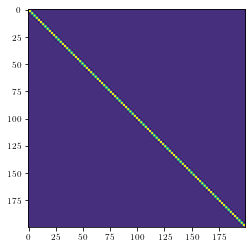

In [92]:
plt.imshow(params.C_f)

In [71]:
params_L.C_f.flatten()[199]

-0.08454196228584486

In [98]:
params_L.C_f[:2,2:4]

array([[ 5.26949905e-17, -7.97765654e-02],
       [ 8.45419623e-02, -2.97835943e-17]])

In [97]:
params_L.C_f[:2,-2:]

array([[-2.97966406e-17, -8.45419623e-02],
       [ 7.97765654e-02,  8.83743013e-18]])

In [100]:
params.C_f[:2,2:4]

array([[ 2.08166817e-17, -7.97765654e-02],
       [ 8.45419623e-02,  2.08166817e-17]])

In [99]:
params.C_f[:2,-2:]

array([[-2.03680539e-16,  2.37437242e-17],
       [ 1.10988106e-16, -2.03680539e-16]])

In [76]:
params_L.C_f[:2,100:102]

array([[ 0.00000000e+00, -1.01593680e-17],
       [-2.71785748e-17, -3.30240325e-17]])

In [77]:
params.C_f[:2,100:102]

array([[-2.39056487e-17,  1.03809771e-16],
       [ 2.02097745e-16, -2.39056487e-17]])

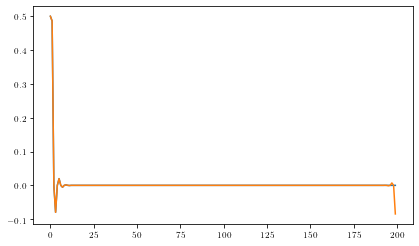

In [95]:
plt.plot(params.C_f[0])
plt.plot(params_L.C_f[0])


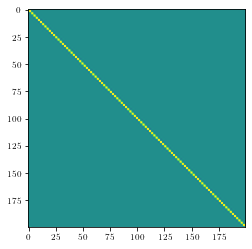

In [91]:
plt.imshow(params_L.C_f)

In [ ]:
params.C_f

In [63]:
params.C_f.flatten()[199]

2.374372418453667e-17

In [64]:
params_L.C_f.flatten()[199]

-0.08454196228584486

In [62]:
np.abs(params.C_f[:8,:8]-params_L.C_f[:8,:8]).flatten()[199]

0.08454196228584489

In [46]:
np.round(params.C_f,4)

array([[ 0.5   , -0.4858,  0.    , ..., -0.    , -0.    , -0.    ],
       [-0.4858,  0.5   , -0.0845, ...,  0.    , -0.    , -0.    ],
       [ 0.    , -0.0845,  0.5   , ...,  0.    ,  0.    , -0.    ],
       ...,
       [-0.    ,  0.    ,  0.    , ...,  0.5   , -0.0845,  0.    ],
       [-0.    , -0.    ,  0.    , ..., -0.0845,  0.5   , -0.4858],
       [-0.    , -0.    , -0.    , ...,  0.    , -0.4858,  0.5   ]])

In [ ]:
params.measure_all_Born(type='link')

In [ ]:
param.P

In [642]:
(params.P_0_list)

[]

In [346]:
len(params.P_0_list)

50

In [649]:
params.projection('e-','link')

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [664]:
z=list(map(lambda x:params.von_Neumann_entropy_f(np.arange(x)),range(10,100,2)))

In [665]:
z2=list(map(lambda x:params.von_Neumann_entropy_m(np.arange(2*x)),range(10,100,2)))

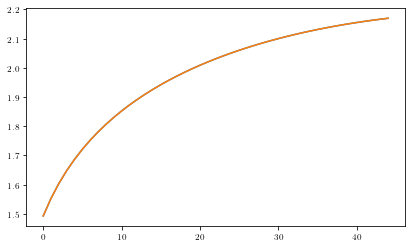

In [666]:
plt.plot(list(z))
plt.plot(list(z2))
# plt.plot(list(zz)/(2*np.log(2)))

In [306]:
params.mutual_information_f(np.arange(10),np.arange(10)+10)

1.3886366811539195

In [307]:
params.mutual_information_m(np.arange(20),np.arange(20)+20)

1.3886366811539588

In [184]:
params.covariance_matrix()

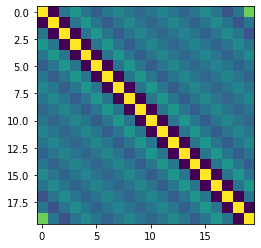

In [185]:
plt.imshow(params.C_f)

In [186]:
print(np.round(params.C_m[:8,:8],4))

[[ 0.      0.      0.      0.6392  0.     -0.      0.     -0.2203]
 [-0.      0.     -0.6392  0.      0.      0.      0.2203  0.    ]
 [ 0.      0.6392  0.      0.      0.      0.6392  0.     -0.    ]
 [-0.6392  0.     -0.      0.     -0.6392  0.      0.      0.    ]
 [ 0.     -0.      0.      0.6392  0.      0.      0.      0.6392]
 [ 0.      0.     -0.6392  0.     -0.      0.     -0.6392  0.    ]
 [ 0.     -0.2203  0.     -0.      0.      0.6392  0.      0.    ]
 [ 0.2203  0.      0.      0.     -0.6392  0.     -0.      0.    ]]


In [188]:
print(np.round(params.C_f[:8,:8],4))

[[ 0.5    -0.3196  0.      0.1101  0.     -0.0707 -0.      0.0561]
 [-0.3196  0.5    -0.3196  0.      0.1101  0.     -0.0707 -0.    ]
 [ 0.     -0.3196  0.5    -0.3196  0.      0.1101  0.     -0.0707]
 [ 0.1101  0.     -0.3196  0.5    -0.3196 -0.      0.1101  0.    ]
 [ 0.      0.1101  0.     -0.3196  0.5    -0.3196  0.      0.1101]
 [-0.0707  0.      0.1101 -0.     -0.3196  0.5    -0.3196  0.    ]
 [-0.     -0.0707  0.      0.1101  0.     -0.3196  0.5    -0.3196]
 [ 0.0561 -0.     -0.0707  0.      0.1101  0.     -0.3196  0.5   ]]


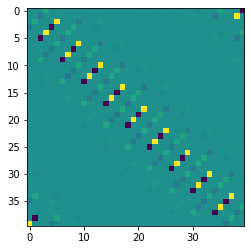

In [99]:
plt.imshow(params.C_m)

In [63]:
def wrap():
    band_list=[]
    for delta in np.linspace(-.1,.1,100):
        params=Params(delta=delta,bc=0)
        params.bandstructure()
        band_list.append(params.val)

(-0.5, 0.5)

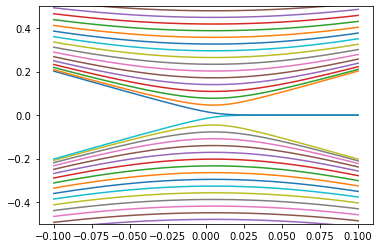

In [60]:
plt.plot(np.linspace(-.1,.1,100),band_list)
# plt.xlim([-1,1])
plt.ylim([-.5,.5])

In [34]:
params.bandstructure()

# No measure/ measure to +1 / measure to -1 / measure following Born rule

In [672]:
delta_list=np.linspace(-1,1,100)**3
MI_no_list=[]
LN_no_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    # params.measure_all(1)
    MI_no_list.append(params.mutual_information_m(np.arange(params.L),np.arange(params.L)+params.L*2))
    LN_no_list.append(params.log_neg(np.arange(params.L),np.arange(params.L)+params.L*2))

In [710]:
delta_list=np.linspace(-1,1,100)**3
MI_neg_list=[]
LN_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    MI_neg_list.append(params.mutual_information_m(np.arange(params.L),np.arange(params.L)+params.L*2))
    LN_neg_list.append(params.log_neg(np.arange(params.L),np.arange(params.L)+params.L*2))

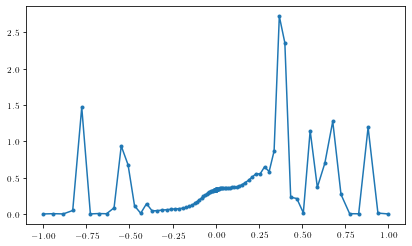

In [709]:
plt.plot(delta_list,LN_neg_list,'.-')

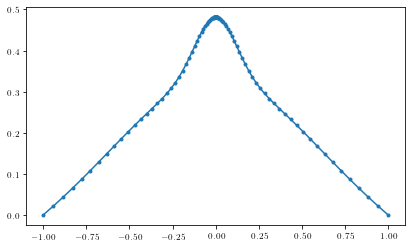

In [701]:
plt.plot(delta_list,LN_neg_list/np.log(2),'.-')

In [711]:
delta_list=np.linspace(-1,1,100)**3
MI_pos_list=[]
LN_pos_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=10,bc=-1)
    params.measure_all(0)
    MI_pos_list.append(params.mutual_information_m(np.arange(params.L),np.arange(params.L)+params.L*2))
    LN_pos_list.append(params.log_neg(np.arange(params.L),np.arange(params.L)+params.L*2))

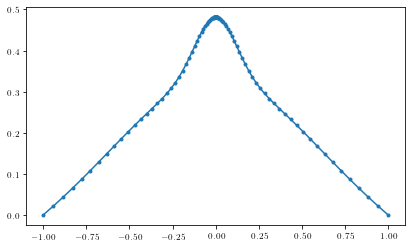

In [714]:
plt.plot(delta_list,LN_pos_list/np.log(2),'.-')

In [675]:
es=100
L=64
MI_Born_list=np.zeros((len(delta_list),(es)))
LN_Born_list=np.zeros((len(delta_list),(es)))
delta=0
for d_i,delta in enumerate(delta_list):
    # # Serial
    # for es_i in range(es):
    #     MI_Born_list[d_i,es_i]=Params(delta=delta,L=L).measure_all_Born().mutual_information_m(np.arange(params.L),np.arange(params.L)+params.L*2)
    #     LN_Born_list[d_i,es_i]=Params(delta=delta,L=L).measure_all_Born().log_neg(np.arange(params.L),np.arange(params.L)+params.L*2)
    
    # Parallel
    async_result=rc[:].map_sync((lambda p:Params(delta=p[0],L=p[1]).measure_all_Born().log_neg(np.arange(p[1]),np.arange(p[1])+p[1]*2)),[(delta,L) for _ in range(es)])
    LN_Born_list[d_i,:]=async_result   

In [676]:
es=100
L=64
MI_link_Born_list=np.zeros((len(delta_list),(es)))
LN_link_Born_list=np.zeros((len(delta_list),(es)))
delta=0
for d_i,delta in enumerate(delta_list):
    # # Serial
    # for es_i in range(es):
    #     MI_link_Born_list[d_i,es_i]=Params(delta=delta,L=L).measure_all_Born().mutual_information_m(np.arange(params.L),np.arange(params.L)+params.L*2)
    #     LN_link_Born_list[d_i,es_i]=Params(delta=delta,L=L).measure_all_Born(type='link').log_neg(np.arange(params.L),np.arange(params.L)+params.L*2)
    
    #Parallel
    async_result=rc[:].map_sync((lambda p:Params(delta=p[0],L=p[1]).measure_all_Born(type='link').log_neg(np.arange(p[1]),np.arange(p[1])+p[1]*2)),[(delta,L) for _ in range(es)])
    LN_link_Born_list[d_i,:]=async_result   

In [475]:
np.array(MI_Born_list).shape

(100, 10)

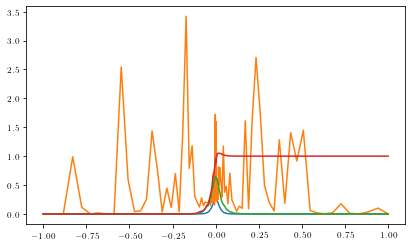

In [680]:
# plt.plot(delta_list,MI_no_list)
plt.plot(delta_list,LN_no_list/np.log(2))

# plt.plot(delta_list,MI_pos_list)
plt.plot(delta_list,LN_pos_list)

# plt.plot(delta_list,MI_neg_list)
# plt.plot(delta_list,LN_neg_list)

# plt.plot(delta_list,np.array(MI_Born_list).mean(axis=1))
plt.plot(delta_list,np.array(LN_Born_list/np.log(2)).mean(axis=1))

plt.plot(delta_list,np.array(LN_link_Born_list/np.log(2)).mean(axis=1))




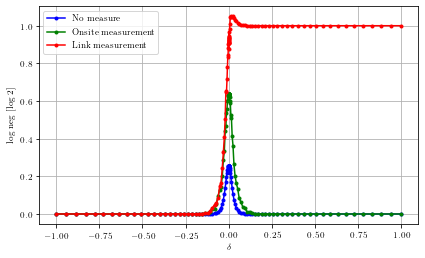

In [681]:
fig,ax=plt.subplots()
colorlist=iter('bgrcmyk')
ax.plot(delta_list,LN_no_list/np.log(2),'.-',label='No measure',color=colorlist.__next__())
ax.plot(delta_list,np.array(LN_Born_list/np.log(2)).mean(axis=1),'.-',label='Onsite measurement',color=colorlist.__next__())
ax.plot(delta_list,np.array(LN_link_Born_list/np.log(2)).mean(axis=1),'.-',label='Link measurement',color=colorlist.__next__())

ax.legend()
ax.grid('on')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'log neg [log 2]')

fig.savefig('/mnt/d/kitp/Rp_SPT/7/LN_Measure.pdf',bbox_inches='tight')

# Scaling at $\delta=0$

## No measurement

In [313]:
eta_no_list=[]
MI_no_list=[]
LN_no_list=[]
L=128
params=Params(delta=0,L=L,bc=-1)
for _ in range(500):
    x=sorted(4*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    eta=cross_ratio(x,4*params.L)
    eta_no_list.append(eta)
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    MI=params.mutual_information_m(subregionA,subregionB)    
    MI_no_list.append(MI)
    LN=params.log_neg(subregionA,subregionB)
    LN_no_list.append(LN)
eta_no_list=np.array(eta_no_list)
MI_no_list=np.array(MI_no_list)
LN_no_list=np.array(LN_no_list)

In [276]:
import matplotlib.patches as mpatches
def place_region(x,y,fig,ax,color='ybyk'):  
    # fig,ax=plt.subplots()
    arc=[mpatches.Arc((x,y),50,50,-theta,0,90,transform=None,ec=ec,lw=5) for theta,ec in zip(np.arange(4)*90,color)]
    [fig.artists.append(arc) for arc in arc]
    ax.text(x+25,y+25,r'$A$',transform=None,ha='center',va='center')
    ax.text(x+25,y-25,r'$A^\prime$',transform=None,ha='center',va='center')
    ax.text(x-25,y-25,r'$B$',transform=None,ha='center',va='center')
    ax.text(x-25,y+25,r'$B^\prime$',transform=None,ha='center',va='center')

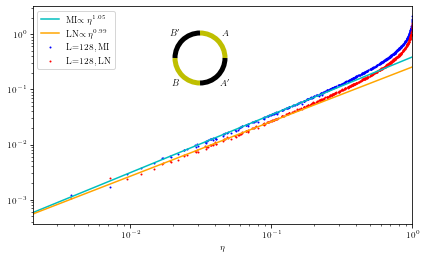

In [353]:
fig,ax=plt.subplots()
ax.scatter(eta_no_list,MI_no_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_no_list,LN_no_list,s=1,color='r',label='L=128, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_no_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_no_list>1e-10)&((eta_no_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_no_list[mask_MI]),np.log(MI_no_list[mask_MI]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_no_list>1e-10)&((eta_no_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_no_list[mask_LN]),np.log(LN_no_list[mask_LN]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ykyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_no.pdf')

## Onsite A'

In [79]:
with open('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_es100_pt100_Ap_onsite.pickle','rb') as f:
    eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list,LN_Born_onsite_Ap_list=pickle.load(f)

In [361]:
eta_Born_onsite_Ap_list=[]
MI_Born_onsite_Ap_list=[]
LN_Born_onsite_Ap_list=[]
# x_list=[]
# subregion_list=[]
es=10
L=128
params_init=Params(delta=0,L=L,bc=-1)
for _ in range(20):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(4*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    eta=cross_ratio(x,4*L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_Ap_list.append(eta)
    MI_Born_onsite_Ap_list.append(MI_ensemble_list)
    LN_Born_onsite_Ap_list.append(LN_ensemble_list)
eta_Born_onsite_Ap_list=np.array(eta_Born_onsite_Ap_list)
MI_Born_onsite_Ap_list=np.array(MI_Born_onsite_Ap_list)
LN_Born_onsite_Ap_list=np.array(LN_Born_onsite_Ap_list)

NameError: name 'place_region' is not defined

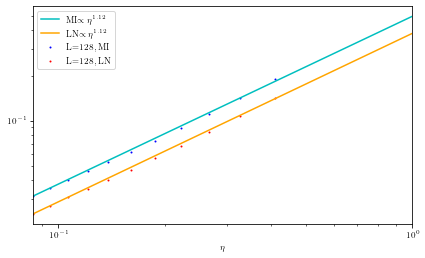

In [82]:
MI_Born_onsite_Ap_list_mean=MI_Born_onsite_Ap_list.mean(axis=1)
LN_Born_onsite_Ap_list_mean=LN_Born_onsite_Ap_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list_mean,s=1,color='b',label='L=128, MI')
ax.scatter(eta_Born_onsite_Ap_list,LN_Born_onsite_Ap_list_mean,s=1,color='r',label='L=128, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_Ap_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_MI]),np.log(MI_Born_onsite_Ap_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_LN]),np.log(LN_Born_onsite_Ap_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyk')
# fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_onsite_Ap.pdf')


## Onsite $A'\cup B'$

In [717]:
with open('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_es100_pt100_ApBp_onsite.pickle','rb') as f:
    eta_Born_onsite_ApBp_list,MI_Born_onsite_ApBp_list,LN_Born_onsite_ApBp_list=pickle.load(f)

In [520]:
eta_Born_onsite_ApBp_list=[]
MI_Born_onsite_ApBp_list=[]
LN_Born_onsite_ApBp_list=[]
# x_list=[]
# subregion_list=[]
es=10
L=128
for _ in range(20):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(4*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    subregionBp=np.concatenate([np.arange(x[3],2*L,2),np.arange(0,x[0],2)])
    eta=cross_ratio(x,4*L)
    for _ in range(es):
        params=Params(delta=0,L=L,bc=-1).measure_all_Born(subregionAp).measure_all_Born(subregionBp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_ApBp_list.append(eta)
    MI_Born_onsite_ApBp_list.append(MI_ensemble_list)
    LN_Born_onsite_ApBp_list.append(LN_ensemble_list)
eta_Born_onsite_ApBp_list=np.array(eta_Born_onsite_ApBp_list)
MI_Born_onsite_ApBp_list=np.array(MI_Born_onsite_ApBp_list)
LN_Born_onsite_ApBp_list=np.array(LN_Born_onsite_ApBp_list)

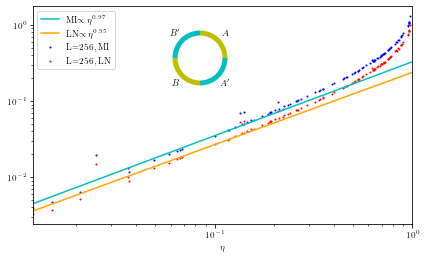

In [718]:
MI_Born_onsite_ApBp_list_mean=MI_Born_onsite_ApBp_list.mean(axis=1)
LN_Born_onsite_ApBp_list_mean=LN_Born_onsite_ApBp_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_ApBp_list,MI_Born_onsite_ApBp_list_mean,s=1,color='b',label='L=256, MI')
ax.scatter(eta_Born_onsite_ApBp_list,LN_Born_onsite_ApBp_list_mean,s=1,color='r',label='L=256, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_ApBp_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_MI]),np.log(MI_Born_onsite_ApBp_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_LN]),np.log(LN_Born_onsite_ApBp_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_onsite_ApBp.pdf')


## Link A'

In [726]:
eta_Born_link_Ap_list=[]
MI_Born_link_Ap_list=[]
LN_Born_link_Ap_list=[]
# x_list=[]
# subregion_list=[]
es=10
L=128
for _ in range(100):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(4*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],4)
    eta=cross_ratio(x,4*L)
    for _ in range(es):
        params=Params(delta=0,L=L,bc=-1).measure_all_Born(subregionAp,type='link')
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_link_Ap_list.append(eta)
    MI_Born_link_Ap_list.append(MI_ensemble_list)
    LN_Born_link_Ap_list.append(LN_ensemble_list)
eta_Born_link_Ap_list=np.array(eta_Born_link_Ap_list)
MI_Born_link_Ap_list=np.array(MI_Born_link_Ap_list)
LN_Born_link_Ap_list=np.array(LN_Born_link_Ap_list)

In [130]:
with open('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_es100_pt500_Ap_link.pickle','rb') as f:
    eta_Born_link_Ap_list,MI_Born_link_Ap_list,LN_Born_link_Ap_list=pickle.load(f)

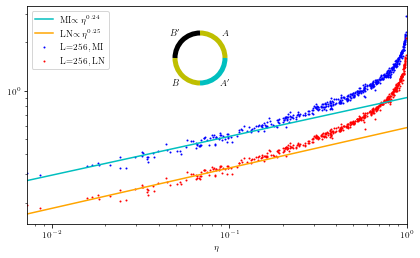

In [133]:
MI_Born_link_Ap_list_mean=MI_Born_link_Ap_list.mean(axis=1)
LN_Born_link_Ap_list_mean=LN_Born_link_Ap_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_link_Ap_list,MI_Born_link_Ap_list_mean,s=1,color='b',label='L=256, MI')
ax.scatter(eta_Born_link_Ap_list,LN_Born_link_Ap_list_mean,s=1,color='r',label='L=256, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_link_Ap_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_link_Ap_list_mean>1e-10)&((eta_Born_link_Ap_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_link_Ap_list[mask_MI]),np.log(MI_Born_link_Ap_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_link_Ap_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_link_Ap_list_mean>1e-10)&((eta_Born_link_Ap_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_link_Ap_list[mask_LN]),np.log(LN_Born_link_Ap_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_link_Ap_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_link_Ap.pdf')


## Link $A'\cup B'$

In [524]:
eta_Born_link_ApBp_list=[]
MI_Born_link_ApBp_list=[]
LN_Born_link_ApBp_list=[]
# x_list=[]
# subregion_list=[]
es=10
L=128
for _ in range(20):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(4*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],4)
    subregionBp=np.concatenate([np.arange(x[3],2*L,4),np.arange(0,x[0],4)])
    eta=cross_ratio(x,4*L)
    for _ in range(es):
        params=Params(delta=0,L=L,bc=-1).measure_all_Born(subregionAp).measure_all_Born(subregionBp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_link_ApBp_list.append(eta)
    MI_Born_link_ApBp_list.append(MI_ensemble_list)
    LN_Born_link_ApBp_list.append(LN_ensemble_list)
eta_Born_link_ApBp_list=np.array(eta_Born_link_ApBp_list)
MI_Born_link_ApBp_list=np.array(MI_Born_link_ApBp_list)
LN_Born_link_ApBp_list=np.array(LN_Born_link_ApBp_list)

In [134]:
with open('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_es100_pt500_ApBp_link.pickle','rb') as f:
    eta_Born_link_ApBp_list,MI_Born_link_ApBp_list,LN_Born_link_ApBp_list=pickle.load(f)

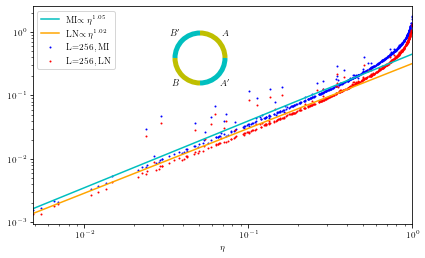

In [135]:
MI_Born_link_ApBp_list_mean=MI_Born_link_ApBp_list.mean(axis=1)
LN_Born_link_ApBp_list_mean=LN_Born_link_ApBp_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_link_ApBp_list,MI_Born_link_ApBp_list_mean,s=1,color='b',label='L=256, MI')
ax.scatter(eta_Born_link_ApBp_list,LN_Born_link_ApBp_list_mean,s=1,color='r',label='L=256, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_link_ApBp_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_link_ApBp_list_mean>1e-10)&((eta_Born_link_ApBp_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_link_ApBp_list[mask_MI]),np.log(MI_Born_link_ApBp_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_link_ApBp_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_link_ApBp_list_mean>1e-10)&((eta_Born_link_ApBp_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_link_ApBp_list[mask_LN]),np.log(LN_Born_link_ApBp_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_link_ApBp_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_Born_link_ApBp.pdf')


# Scaling at $\delta=0$ for infinite long wire

In [4]:
import matplotlib.patches as mpatches
def place_region_wire(x,y,fig,ax,color='yky'):  
    # fig,ax=plt.subplots()
    arc=[mpatches.Arc((x,y),50,50,-theta,0,90,transform=None,ec=ec,lw=5) for theta,ec in zip(np.arange(4)*90,color)]
    lineA=mpatches.Rectangle((x,y),50,5,transform=None,fc=color[0],lw=0)
    lineAp=mpatches.Rectangle((x+50,y),100,5,transform=None,fc=color[1],lw=0)
    lineB=mpatches.Rectangle((x+150,y),50,5,transform=None,fc=color[2],lw=0)
    [fig.artists.append(line) for line in (lineA,lineAp,lineB)]
    ax.text(x+25,y+10,r'$A$',transform=None,ha='center',va='center')
    ax.text(x+100,y+10,r'$A^\prime$',transform=None,ha='center',va='center')
    ax.text(x+175,y+10,r'$B$',transform=None,ha='center',va='center')

In [13]:
eta_inf_no_list=[]
MI_inf_no_list=[]
LN_inf_no_list=[]
L=np.inf
dist_list=range(4,256)
params=Params(delta=0,L=L,bc=-1,dmax=dist_list[-1]+32)
for d in dist_list:
    x=np.array([0,16,16+d,32+d])*4
    eta=cross_ratio(x,L)
    eta_inf_no_list.append(eta)
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    MI=params.mutual_information_m(subregionA,subregionB)    
    MI_inf_no_list.append(MI)
    LN=params.log_neg(subregionA,subregionB)
    LN_inf_no_list.append(LN)
eta_inf_no_list=np.array(eta_inf_no_list)
MI_inf_no_list=np.array(MI_inf_no_list)
LN_inf_no_list=np.array(LN_inf_no_list)

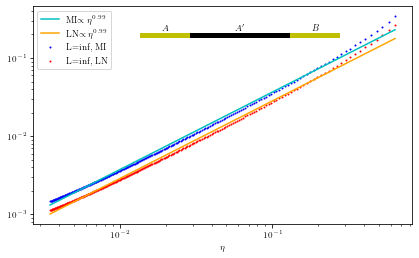

In [14]:
fig,ax=plt.subplots()
ax.scatter(eta_inf_no_list,MI_inf_no_list,s=1,color='b',label='L={}, MI'.format(L))
ax.scatter(eta_inf_no_list,LN_inf_no_list,s=1,color='r',label='L={}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([np.min(eta_inf_no_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_inf_no_list>1e-10)&((eta_inf_no_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_inf_no_list[mask_MI]),np.log(MI_inf_no_list[mask_MI]))
x_int=np.linspace(np.min(eta_inf_no_list),np.max(eta_inf_no_list),2)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_inf_no_list>1e-10)&((eta_inf_no_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_inf_no_list[mask_LN]),np.log(LN_inf_no_list[mask_LN]))
x_int=np.linspace(np.min(eta_inf_no_list),np.max(eta_inf_no_list),2)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region_wire(140,220,fig,ax,color='yky')
fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_inf_no.pdf')

## onsite A'

In [72]:
with open('/mnt/d/kitp/Rp_SPT/7/MI_LN_SSH_inf_Born_En100_onsite_(8,100).pickle','rb') as f:
    [dist_list,eta_inf_Born_onsite_Ap_list,MI_inf_Born_onsite_Ap_list,LN_inf_Born_onsite_Ap_list]=pickle.load(f)

In [86]:
with open('MI_LN_SSH_inf_Born_En100_onsite_den(1,1)_dist(8,40).pickle','rb') as f:
    [dist_list,eta_inf_Born_onsite_Ap_list,MI_inf_Born_onsite_Ap_list,LN_inf_Born_onsite_Ap_list]=pickle.load(f)

In [64]:
eta_inf_Born_onsite_Ap_list=[]
MI_inf_Born_onsite_Ap_list=[]
LN_inf_Born_onsite_Ap_list=[]
es=100
L=np.inf
dist_list=range(8,40)
params_init=Params(delta=0,L=L,bc=-1,dmax=dist_list[-1]+32)
for d in dist_list:
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=np.array([0,16,16+d,32+d])*4
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    eta=cross_ratio(x,4*L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_inf_Born_onsite_Ap_list.append(eta)
    MI_inf_Born_onsite_Ap_list.append(MI_ensemble_list)
    LN_inf_Born_onsite_Ap_list.append(LN_ensemble_list)
eta_inf_Born_onsite_Ap_list=np.array(eta_inf_Born_onsite_Ap_list)
MI_inf_Born_onsite_Ap_list=np.array(MI_inf_Born_onsite_Ap_list)
LN_inf_Born_onsite_Ap_list=np.array(LN_inf_Born_onsite_Ap_list)

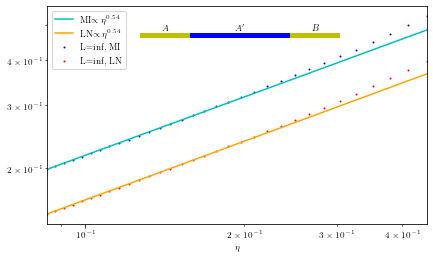

In [87]:
MI_inf_Born_onsite_Ap_list_mean=MI_inf_Born_onsite_Ap_list.mean(axis=1)
LN_inf_Born_onsite_Ap_list_mean=LN_inf_Born_onsite_Ap_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_inf_Born_onsite_Ap_list,MI_inf_Born_onsite_Ap_list_mean,s=1,color='b',label='L={}, MI'.format(L))
ax.scatter(eta_inf_Born_onsite_Ap_list,LN_inf_Born_onsite_Ap_list_mean,s=1,color='r',label='L={}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_inf_Born_onsite_Ap_list),np.max(eta_inf_Born_onsite_Ap_list)])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_inf_Born_onsite_Ap_list_mean>1e-10)&((eta_inf_Born_onsite_Ap_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_inf_Born_onsite_Ap_list[mask_MI]),np.log(MI_inf_Born_onsite_Ap_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_inf_Born_onsite_Ap_list),np.max(eta_inf_Born_onsite_Ap_list),10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_inf_Born_onsite_Ap_list_mean>1e-10)&((eta_inf_Born_onsite_Ap_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_inf_Born_onsite_Ap_list[mask_LN]),np.log(LN_inf_Born_onsite_Ap_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_inf_Born_onsite_Ap_list),np.max(eta_inf_Born_onsite_Ap_list),10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()
place_region_wire(140,220,fig,ax,color='yby')
# fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_inf_Born_onsite_Ap.pdf')


## Link A'

In [59]:
with open('/mnt/d/kitp/Rp_SPT/7/MI_LN_SSH_inf_Born_En1000_link_(8,100).pickle','rb') as f:
    [dist_list,eta_inf_Born_link_Ap_list,MI_inf_Born_link_Ap_list,LN_inf_Born_link_Ap_list]=pickle.load(f)

In [ ]:
eta_inf_Born_link_Ap_list=[]
MI_inf_Born_link_Ap_list=[]
LN_inf_Born_link_Ap_list=[]
es=1000
L=np.inf
dist_list=range(8,100)
params_init=Params(delta=0,L=L,bc=-1,dmax=dist_list[-1]+32)
for d in dist_list:
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=np.array([0,16,16+d,32+d])*4
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],4)
    eta=cross_ratio(x,4*L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp,type='link')
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_inf_Born_link_Ap_list.append(eta)
    MI_inf_Born_link_Ap_list.append(MI_ensemble_list)
    LN_inf_Born_link_Ap_list.append(LN_ensemble_list)
eta_inf_Born_link_Ap_list=np.array(eta_inf_Born_link_Ap_list)
MI_inf_Born_link_Ap_list=np.array(MI_inf_Born_link_Ap_list)
LN_inf_Born_link_Ap_list=np.array(LN_inf_Born_link_Ap_list)

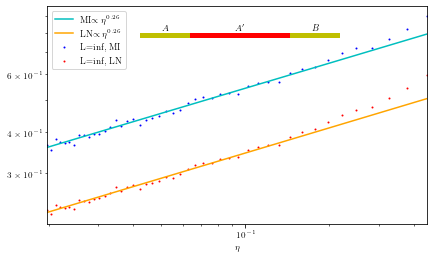

In [60]:
MI_inf_Born_link_Ap_list_mean=MI_inf_Born_link_Ap_list.mean(axis=1)
LN_inf_Born_link_Ap_list_mean=LN_inf_Born_link_Ap_list.mean(axis=1)

MI_inf_Born_link_Ap_list_mean_even=MI_inf_Born_link_Ap_list_mean[np.array(dist_list)%2==0]
LN_inf_Born_link_Ap_list_mean_even=LN_inf_Born_link_Ap_list_mean[np.array(dist_list)%2==0]
eta_inf_Born_link_Ap_list_even=eta_inf_Born_link_Ap_list[np.array(dist_list)%2==0]
fig,ax=plt.subplots()
ax.scatter(eta_inf_Born_link_Ap_list_even,MI_inf_Born_link_Ap_list_mean_even,s=1,color='b',label='L={}, MI'.format(L))
ax.scatter(eta_inf_Born_link_Ap_list_even,LN_inf_Born_link_Ap_list_mean_even,s=1,color='r',label='L={}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_inf_Born_link_Ap_list_even),np.max(eta_inf_Born_link_Ap_list_even)])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_inf_Born_link_Ap_list_mean_even>1e-10)&((eta_inf_Born_link_Ap_list_even)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_inf_Born_link_Ap_list_even[mask_MI]),np.log(MI_inf_Born_link_Ap_list_mean_even[mask_MI]))
x_int=np.linspace(np.min(eta_inf_Born_link_Ap_list_even),np.max(eta_inf_Born_link_Ap_list_even),10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_inf_Born_link_Ap_list_mean_even>1e-10)&((eta_inf_Born_link_Ap_list_even)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_inf_Born_link_Ap_list_even[mask_LN]),np.log(LN_inf_Born_link_Ap_list_mean_even[mask_LN]))
x_int=np.linspace(np.min(eta_inf_Born_link_Ap_list_even),np.max(eta_inf_Born_link_Ap_list_even),10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region_wire(140,220,fig,ax,color='yry')
fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_inf_Born_link_Ap_even.pdf')


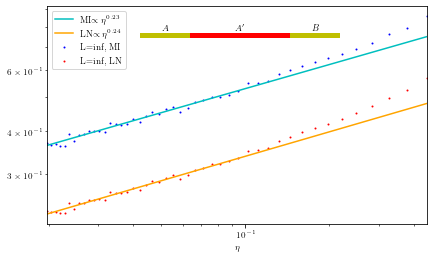

In [61]:
MI_inf_Born_link_Ap_list_mean=MI_inf_Born_link_Ap_list.mean(axis=1)
LN_inf_Born_link_Ap_list_mean=LN_inf_Born_link_Ap_list.mean(axis=1)

MI_inf_Born_link_Ap_list_mean_odd=MI_inf_Born_link_Ap_list_mean[np.array(dist_list)%2==1]
LN_inf_Born_link_Ap_list_mean_odd=LN_inf_Born_link_Ap_list_mean[np.array(dist_list)%2==1]
eta_inf_Born_link_Ap_list_odd=eta_inf_Born_link_Ap_list[np.array(dist_list)%2==0]
fig,ax=plt.subplots()
ax.scatter(eta_inf_Born_link_Ap_list_odd,MI_inf_Born_link_Ap_list_mean_odd,s=1,color='b',label='L={}, MI'.format(L))
ax.scatter(eta_inf_Born_link_Ap_list_odd,LN_inf_Born_link_Ap_list_mean_odd,s=1,color='r',label='L={}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_inf_Born_link_Ap_list_odd),np.max(eta_inf_Born_link_Ap_list_odd)])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_inf_Born_link_Ap_list_mean_odd>1e-10)&((eta_inf_Born_link_Ap_list_odd)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_inf_Born_link_Ap_list_odd[mask_MI]),np.log(MI_inf_Born_link_Ap_list_mean_odd[mask_MI]))
x_int=np.linspace(np.min(eta_inf_Born_link_Ap_list_odd),np.max(eta_inf_Born_link_Ap_list_odd),10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_inf_Born_link_Ap_list_mean_odd>1e-10)&((eta_inf_Born_link_Ap_list_odd)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_inf_Born_link_Ap_list_odd[mask_LN]),np.log(LN_inf_Born_link_Ap_list_mean_odd[mask_LN]))
x_int=np.linspace(np.min(eta_inf_Born_link_Ap_list_odd),np.max(eta_inf_Born_link_Ap_list_odd),10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region_wire(140,220,fig,ax,color='yry')
fig.savefig('/mnt/d/kitp/Rp_SPT/7/MI_LN_inf_Born_link_Ap_odd.pdf')


## Dep of operator density

# von Neumann entropy

In [25]:
def generate_A_dep(w):
    subregion_max_list=np.arange(2,50,2)
    von_Neumann_entropy_list[w]=[]
    params=Params(w=w,L=200)
    for subregion_max in subregion_max_list:
        von_Neumann_entropy_list[w].append(params.von_Neumann_entropy(np.arange(subregion_max)))

In [4]:
def generate_A_dep_2(w):
    subregion_max_list=np.arange(20,100,2)
    von_Neumann_entropy_list[w]=[]    
    for subregion_max in subregion_max_list:
        params=Params(w=w,L=subregion_max*4)
        von_Neumann_entropy_list[w].append(params.von_Neumann_entropy(np.arange(subregion_max)))

In [26]:
von_Neumann_entropy_list={}
for i in (0,0.5,0.8,1,2):
    generate_A_dep(i)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
for i in (0,0.5,.8,1,2):
    generate_A_dep_2(i)

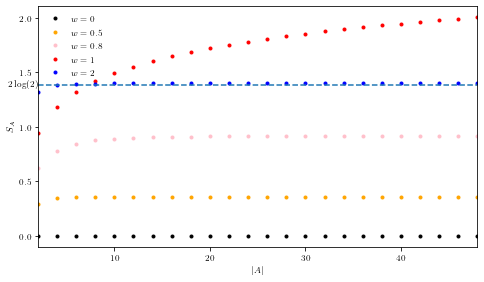

In [27]:
fig,ax=plt.subplots(figsize=(6.8,4))
subregion_max_list=np.arange(2,50,2)
for i,color in zip((0,0.5,0.8,1,2),('k','orange','pink','red','b')):
    ax.plot(subregion_max_list,von_Neumann_entropy_list[i],'.',label=r'$w={}$'.format((i)),color=color)
ax.legend(framealpha=0)
# ax.plot(subregion_max_list,1/3*np.log(subregion_max_list))
ax.margins(x=0)
ax.axhline(y=2*np.log(2),ls='--')
ax.text(2,2*np.log(2),r'$2\log(2)$',ha='right',va='center')
ax.set_xlabel(r'$|A|$')
ax.set_ylabel(r'$S_A$')
ax.set_yticks(np.arange(0,2.5,0.5))

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/1/SA_vs_A_L_fixed.pdf',bbox_inches='tight')

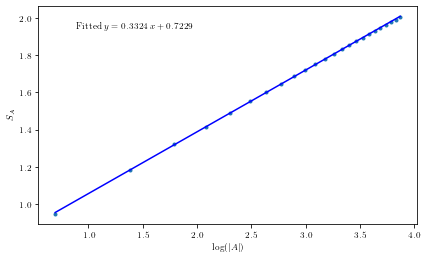

In [31]:
fig,ax=plt.subplots(figsize=(6.8,4))
ax.plot(np.log(subregion_max_list),(von_Neumann_entropy_list[1]),'.')
ax.set_xlabel(r'$\log(|A|)$')
ax.set_ylabel(r'$S_A$')
lr=scipy.stats.linregress(np.log(subregion_max_list),(von_Neumann_entropy_list[1]))
ax.plot(np.log(subregion_max_list),lr.slope*np.log(subregion_max_list)+lr.intercept,'b')
ax.text(0.1,0.9,r'Fitted $y={:.4f}~x+ {:.4f}$'.format(lr.slope,lr.intercept),transform=ax.transAxes)
fig.savefig('/mnt/d/kitp/Rp_SPT/1/critical_exponent.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
subregion_max_list=np.arange(20,100,2)
for i,color in zip((0,0.5,0.8,1,2),('k','orange','pink','red','b')):
    ax.plot(subregion_max_list,von_Neumann_entropy_list[i],'.',label=r'$\mu={}$'.format((i)),color=color)
ax.legend()
# ax.plot(subregion_max_list,1/3*np.log(subregion_max_list))
ax.margins(x=0)
ax.axhline(y=np.log(2),ls='--')
ax.text(-1,np.log(2),r'$\log(2)$')
ax.set_xlabel(r'$|A|$')
ax.set_ylabel(r'$S_A$')

# fig.savefig('/mnt/d/kitp/Rp_SPT/1/SA_vs_A_L_fixed.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
ax.plot(np.log(subregion_max_list),(von_Neumann_entropy_list[1]))
ax.set_xlabel(r'$\log(|A|)$')
ax.set_ylabel(r'$S_A$')
ax.text(0.1,0.9,r'Fitted $y=0.1676~x+ 0.354$',transform=ax.transAxes)
# fig.savefig('/mnt/d/kitp/Rp_SPT/1/critical_exponent.pdf',bbox_inches='tight')

In [ ]:
w_list=np.linspace(0.01,2,50)
von_Neumann_entropy_w_list=[]
spectrum_gap_list=[]
for w in w_list:
    params=Params(w=w,L=100)
    von_Neumann_entropy_w_list.append(params.von_Neumann_entropy(np.arange(10)))
    val=params.val
    spectrum_gap_list.append(np.max(val[val<0])-np.min(val[val>0]))

In [ ]:
plt.plot(w_list,von_Neumann_entropy_w_list)
plt.plot(w_list,np.abs(spectrum_gap_list))

In [ ]:
plt.plot(w_list,np.abs(spectrum_gap_list))

In [ ]:
derivative=(np.array(von_Neumann_entropy_w_list[2:])-np.array(von_Neumann_entropy_w_list[:-2]))/(w_list[1]-w_list[0])

In [ ]:
plt.plot(w_list[1:-1],np.abs(derivative))

In [ ]:
fig,ax=plt.subplots()
for index in range(eigvallist[0].shape[0]):
    ax.plot(wlist,np.array(eigvallist)[:,index],'k')
    ax.set_ylim([-2,2])


# Mutual information

In [6]:
MI_list={}

## w=0.5

In [10]:
dist_list=np.arange(10,50,2)
MI_list[0.5]=[]
params=Params(w=0.5,L=200)
for dist in dist_list:
    MI_list[.5].append(params.mutual_information(np.arange(10),np.arange(dist,dist+10)))

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


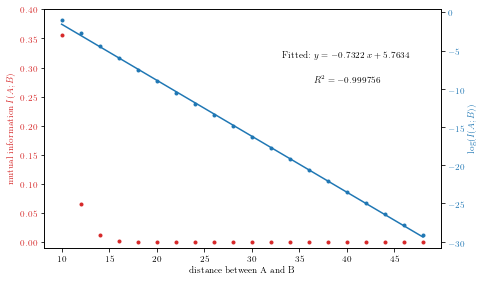

In [15]:
fig,ax1=plt.subplots(figsize=(6.8,4))

color = 'tab:red'
ax1.set_xlabel('distance between A and B')
ax1.set_ylabel(r'mutual information $I(A;B)$', color=color)
ax1.plot(dist_list,MI_list[.5],'.', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.01,0.4)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel(r'$\log(I(A;B))$', color=color)  
ax2.plot(dist_list,np.log(MI_list[.5]),'.', color=color)
ax2.tick_params(axis='y', labelcolor=color)
lr=scipy.stats.linregress(dist_list,np.log(MI_list[.5]))
ax2.text(.6,.8,r'Fitted: $y={:.4f}~x+{:.4f}$'.format(lr.slope,lr.intercept),transform=ax2.transAxes)
ax2.text(.68,.7,r'$R^2={:f}$'.format(lr.rvalue),transform=ax2.transAxes)

ax2.plot(dist_list,lr.slope*dist_list+lr.intercept,color=color)

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/1/MI_mu0.5.pdf',bbox_inches='tight')


## w=2

In [7]:
dist_list=np.arange(10,50,2)
MI_list[2]=[]
params=Params(w=2,L=200)
for dist in dist_list:
    MI_list[2].append(params.mutual_information(np.arange(10),np.arange(dist,dist+10)))

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


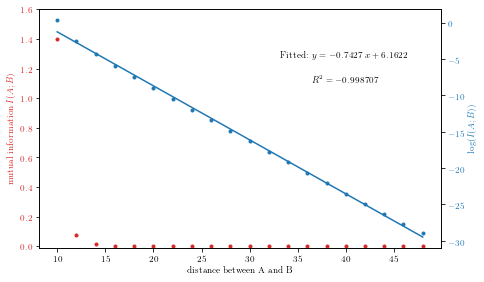

In [11]:
fig,ax1=plt.subplots(figsize=(6.8,4))

color = 'tab:red'
ax1.set_xlabel('distance between A and B')
ax1.set_ylabel(r'mutual information $I(A;B)$', color=color)
ax1.plot(dist_list,MI_list[2],'.', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.01,1.6)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel(r'$\log(I(A;B))$', color=color)  
ax2.plot(dist_list,np.log(MI_list[2]), '.',color=color)
ax2.tick_params(axis='y', labelcolor=color)
lr=scipy.stats.linregress(dist_list,np.log(MI_list[2]))
ax2.text(.6,.8,r'Fitted: $y={:.4f}~x+{:.4f}$'.format(lr.slope,lr.intercept),transform=ax2.transAxes)
ax2.text(.68,.7,r'$R^2={:f}$'.format(lr.rvalue),transform=ax2.transAxes)

ax2.plot(dist_list,lr.slope*dist_list+lr.intercept,color=color)

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/1/MI_mu2.pdf',bbox_inches='tight')


In [12]:
1/lr.slope

-1.346454691943884

## w=1

In [13]:
dist_list=np.arange(10,190,2)
MI_list[1]=[]
params=Params(w=1,L=200)
for dist in dist_list:
    MI_list[1].append(params.mutual_information(np.arange(10),np.arange(dist,dist+10)))

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


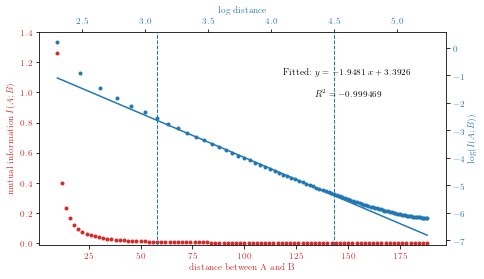

In [60]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2",frame_on=False)

color = 'tab:red'
ax1.set_xlabel('distance between A and B', color=color)
ax1.set_ylabel(r'mutual information $I(A;B)$', color=color)
ax1.plot(dist_list,MI_list[1],'.', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.set_ylim(-0.01,1.4)

color = 'tab:blue'
ax2.plot(np.log(dist_list),np.log(MI_list[1]),'.', color=color)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel(r'log distance', color=color)
ax2.set_ylabel(r'$\log(I(A;B))$', color=color)  
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='x', labelcolor=color)

mask=(np.log(dist_list)<4.5)*(np.log(dist_list)>3)
lr=scipy.stats.linregress(np.log(dist_list)[mask],np.log(MI_list[1])[mask])
ax2.text(.6,.8,r'Fitted: $y={:.4f}~x+{:.4f}$'.format(lr.slope,lr.intercept),transform=ax2.transAxes)
ax2.text(.68,.7,r'$R^2={:f}$'.format(lr.rvalue),transform=ax2.transAxes)
ax2.plot(np.log(dist_list),lr.slope*np.log(dist_list)+lr.intercept,color=color)

ax2.axvline(x=np.log(dist_list)[mask][0],lw=1,ls='--')
ax2.axvline(x=np.log(dist_list)[mask][-1],lw=1,ls='--')

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/1/MI_mu1.pdf',bbox_inches='tight')

In [46]:

dist_list[0]

10

In [44]:
np.log(22)

3.091042453358316

In [42]:

np.log(dist_list)[mask]

array([3.09104245, 3.17805383, 3.25809654, 3.33220451, 3.40119738,
       3.4657359 , 3.52636052, 3.58351894, 3.63758616, 3.68887945,
       3.73766962, 3.78418963, 3.8286414 , 3.87120101, 3.91202301,
       3.95124372, 3.98898405, 4.02535169, 4.06044301, 4.09434456,
       4.12713439, 4.15888308, 4.18965474, 4.21950771, 4.24849524,
       4.27666612, 4.30406509, 4.33073334, 4.35670883, 4.38202663,
       4.40671925, 4.4308168 , 4.4543473 , 4.47733681, 4.49980967])

In [39]:

np.log(dist_list)[mask][0]

3.091042453358316

In [33]:
np.exp([3,4.5])

array([20.08553692, 90.0171313 ])

In [34]:

np.log(20)

2.995732273553991

# Class

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la

In [2]:
class Params_o:
    def __init__(self,
    L=100,
    v=1,
    w=1,
    T=0,
    pbc=True):
        self.L=L
        self.v=v
        self.w=w
        self.T=T
        self.pbc=pbc
        band=np.vstack([np.ones(L)*v,np.ones(L)*w]).flatten('F')        
        Ham=sp.diags(np.array([band[:-1],band[:-1]]),np.array([-1,1]),shape=(2*L,2*L)).tocsr()
        Ham[0,2*L-1]=w*pbc
        Ham[2*L-1,0]=w*pbc
        self.Hamiltonian=Ham

    def fermi_dist(self,energy,E_F):      
        if self.T==0:
            return np.heaviside(E_F-energy,0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def bandstructure(self):
        val,vec=la.eigh(self.Hamiltonian.toarray())
        sortindex=np.argsort(val)
        self.val=val[sortindex]
        self.vec=vec[:,sortindex]

    def covariance_matrix_loop(self):
        '''
        Use loop to calculate covariance matrix (deprecated)
        '''
        self.C_loop=np.zeros((2*self.L,2*self.L))
        for i in range(2*self.L):
            for j in range(2*self.L):
                self.C_loop[i,j]=self.c_ij(i,j)

    def covariance_matrix(self,E_F=0):
        if not (hasattr(self,'val') and hasattr(self,'vec')):
            self.bandstructure()
        occupancy=self.fermi_dist(self.val,E_F)
        occupancy_mat=np.matlib.repmat(self.fermi_dist(self.val,E_F),self.vec.shape[0],1)
        self.C=(occupancy_mat*self.vec)@self.vec.T.conj()
        


    def c_ij(self,i,j,E_F=0):
        if not (hasattr(self,'val') and hasattr(self,'vec')):
            self.bandstructure()

        occupancy=self.fermi_dist(self.val,E_F)
        bra_i=self.vec[i,:] # c_i
        ket_j=self.vec[j,:] # c_j
        return np.sum(bra_i.conj()*ket_j*occupancy)

    def c_subregion(self,subregion):
        if not hasattr(self,'C'):
            self.covariance_matrix()
        XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
        mask=np.isin(XX,subregion)*np.isin(YY,subregion)        
        return self.C[mask].reshape((subregion.shape[0],subregion.shape[0]))

    def von_Neumann_entropy(self,subregion):
        c_A=self.c_subregion(subregion)
        val,vec=la.eigh(c_A)
        self.val_sh=val
        # return np.real(-np.sum(val*np.log(val+1e-18j)))
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def mutual_information(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy(subregion_A)
        s_B=self.von_Neumann_entropy(subregion_B)
        subregion_AB=np.hstack([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy(subregion_AB)
        return s_A+s_B-s_AB

In [303]:
params_o=Params_o(v=1-0.5,w=1+0.5,L=100)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [304]:
params_o.mutual_information(np.arange(10),np.arange(10)+10)

1.3886366811539332

In [269]:
zz=list(map(lambda x:params_o.von_Neumann_entropy(np.arange(x)),range(10,100,2)))

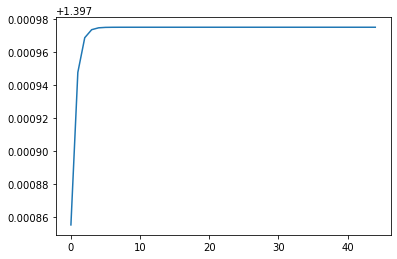

In [270]:
plt.plot(zz)

In [151]:
print(np.round(params_o.C[:6,:6],4))

[[ 0.5 -0.5  0.   0.   0.   0. ]
 [-0.5  0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.5 -0.5  0.   0. ]
 [ 0.   0.  -0.5  0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.5 -0.5]
 [ 0.   0.   0.   0.  -0.5  0.5]]


In [9]:
band_list=[]
for v in np.linspace(0,2,100):
    params=Params_o(v=v,pbc=False)
    params.bandstructure()
    band_list.append(params.val)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [10]:
band_list=np.array(band_list)

(-1.0, 1.0)

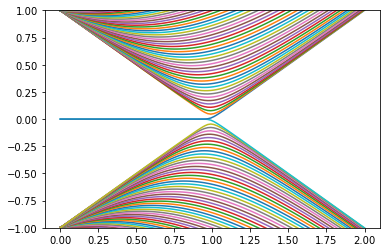

In [12]:
plt.plot(np.linspace(0,2,100),band_list)
plt.ylim([-1,1])

array([-2.00000000e+00, -1.99901312e+00, -1.99901312e+00, -1.99605346e+00,
       -1.99605346e+00, -1.99112393e+00, -1.99112393e+00, -1.98422940e+00,
       -1.98422940e+00, -1.97537668e+00, -1.97537668e+00, -1.96457450e+00,
       -1.96457450e+00, -1.95183352e+00, -1.95183352e+00, -1.93716632e+00,
       -1.93716632e+00, -1.92058737e+00, -1.92058737e+00, -1.90211303e+00,
       -1.90211303e+00, -1.88176154e+00, -1.88176154e+00, -1.85955297e+00,
       -1.85955297e+00, -1.83550925e+00, -1.83550925e+00, -1.80965410e+00,
       -1.80965410e+00, -1.78201305e+00, -1.78201305e+00, -1.75261336e+00,
       -1.75261336e+00, -1.72148405e+00, -1.72148405e+00, -1.68865585e+00,
       -1.68865585e+00, -1.65416115e+00, -1.65416115e+00, -1.61803399e+00,
       -1.61803399e+00, -1.58031002e+00, -1.58031002e+00, -1.54102649e+00,
       -1.54102649e+00, -1.50022214e+00, -1.50022214e+00, -1.45793725e+00,
       -1.45793725e+00, -1.41421356e+00, -1.41421356e+00, -1.36909421e+00,
       -1.36909421e+00, -